In [ ]:
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np
import keras_tuner as kt
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from functools import partial 
import seaborn as sb

from scikeras.wrappers import KerasRegressor



# Comparison of Regressors for Abalone Age Prediction

In this assignment, the objective is to compare the performance of different regressors on the Abalone dataset. What is the best algorithm for the dataset? How does ANNs compare to other ML methods? What is the best ANN architecture?

In [4]:
abalone_data = pd.read_csv('data/abalone.data')
abalone_data.head()

,M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15
0,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
1,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
3,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
4,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


# Describe the dataset:
This dataset is supposed to predict the age of an abalone. The features contain information about the abalones gender and size. the features: one of them are categorical and the rest are continious
the target tells how many rings the target has, which is used to determine the age in years, since this is a regression problem the target is a  
  
the uci link tells us that the missing values were removed from the dataset, and that the ranges of the continuous vales have been scaled.  
https://archive.ics.uci.edu/dataset/1/abalone

# preprocessing of the data
just to make it easier to use the different functions and to make it more understandable for me

# renaming columns
just to make it easier for me to understand what the different columns represent

In [5]:
abalone_data.rename(columns={
    'M': 'Sex', 
    '0.455': 'Length', 
    '0.365': 'Diameter',
    '0.095': 'Height',
    '0.514': 'Whole_weight',
    '0.2245': 'Shucked_weight', 
    '0.101': 'Viscera_weight', 
    '0.15': 'Shell_weight', 
    '15': 'Rings'
}, inplace=True)


In [6]:
abalone_data.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
1,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
3,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
4,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


# encoding categorical value
to make it easier for the functions used later

In [7]:
label_encoder = LabelEncoder()

abalone_data['Sex'] = label_encoder.fit_transform(abalone_data['Sex'])

abalone_data.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
1,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
3,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
4,1,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


# 

# Perform exploratory analysis of the dataset

# Distribution of the features and target:
looking at the distribution of the features it looks like most of them are normally distributed, besides the column M for gender.  
this means that the models we can use are mlp regressor sklearn and sequential mode. but we need to remember to scale the data, because this will make it easier for the neural network models to learn with

array([[<Axes: title={'center': 'Sex'}>,
        <Axes: title={'center': 'Length'}>,
        <Axes: title={'center': 'Diameter'}>],
       [<Axes: title={'center': 'Height'}>,
        <Axes: title={'center': 'Whole_weight'}>,
        <Axes: title={'center': 'Shucked_weight'}>],
       [<Axes: title={'center': 'Viscera_weight'}>,
        <Axes: title={'center': 'Shell_weight'}>,
        <Axes: title={'center': 'Rings'}>]], dtype=object)

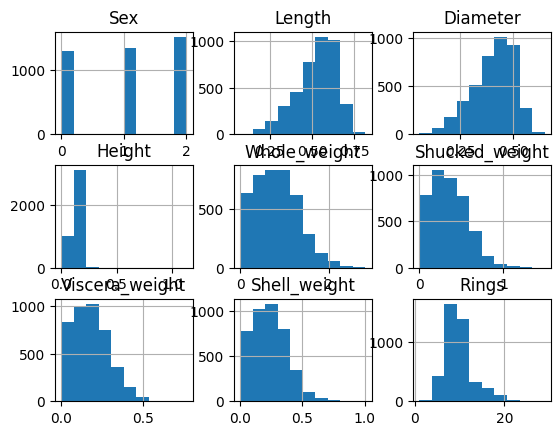

In [8]:
abalone_data.hist()

# Correlation analysis
it looks like the features of the dataset are heavily correlated, beside the M feature and the target. some sort of dimention reduction can be helpful for this dataset.

In [9]:
abalone_corr = abalone_data.corr()
abalone_corr.style.background_gradient(cmap='coolwarm')

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
Sex,1.000000,-0.035915,-0.038762,-0.041796,-0.021219,-0.001205,-0.031873,-0.034686,-0.035076
Length,-0.035915,1.000000,0.986813,0.827552,0.925255,0.897905,0.903010,0.897697,0.557123
Diameter,-0.038762,0.986813,1.000000,0.833705,0.925452,0.893159,0.899726,0.905328,0.575005
Height,-0.041796,0.827552,0.833705,1.000000,0.819209,0.774957,0.798293,0.817326,0.558109
Whole_weight,-0.021219,0.925255,0.925452,0.819209,1.000000,0.969403,0.966372,0.955351,0.540818
Shucked_weight,-0.001205,0.897905,0.893159,0.774957,0.969403,1.000000,0.931956,0.882606,0.421256
Viscera_weight,-0.031873,0.903010,0.899726,0.798293,0.966372,0.931956,1.000000,0.907647,0.504274
Shell_weight,-0.034686,0.897697,0.905328,0.817326,0.955351,0.882606,0.907647,1.000000,0.628031
Rings,-0.035076,0.557123,0.575005,0.558109,0.540818,0.421256,0.504274,0.628031,1.000000


# Perform necessary pre-processing of data after exploratory analysis
The changes i make to the dataset will be put in different pipes, to make an alternative dataset to test the models with. The pipe also makes sure that the changes only tuch the training data and not the test data.

# scaling the data

In [10]:
scaler = StandardScaler()

# PCA (dimension reduction)
we can take all of the correlated features 0.45, 0.365, 0.095, 0.514, 0.2245, 0.101 and 0.15
and reduce their dimentionality, this could make it easier for the model to see patterns and undertsnad the information when there is no need for this many features.

[0.97409888 0.98551837 0.99389476 0.99693366 0.99834385 0.99957334
 1.        ]


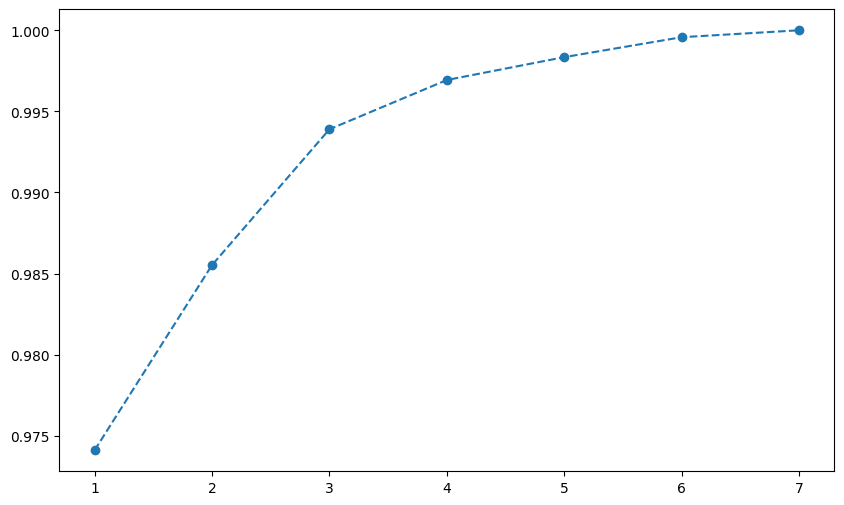

In [11]:
pca = PCA()
number_of_pca = pca.fit_transform(abalone_data.iloc[:, 1:8])
number_of_pca

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print(cumulative_variance)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.show()

# here we can see that combining these features to 2 columns still retains a lot of information

In [12]:
pca = ColumnTransformer([
     ("pca", PCA(2), slice(1, 8))] , remainder='passthrough') 

# pipe with changed data
i will make a pipe for every change so that i can find the best.

In [13]:
def pipe_with_scaler(model):
    return Pipeline([('scaler', scaler), ('regressor', model)])

In [14]:
def pipe_with_scaler_and_pca(model):
    return Pipeline([('scaler', scaler), ('pca', pca),('regressor', model)])

# Split the dataset into suitable partitions

In [15]:
features = abalone_data.drop('Rings', axis=1)
targets = abalone_data['Rings']

train_val_features, test_features, train_val_targets, test_targets = train_test_split(features, targets, test_size=0.2)

In [16]:
print(train_val_features.shape, train_val_targets.shape, test_features.shape, test_targets.shape)

(3340, 8) (3340,) (836, 8) (836,)


# finding out which alterations of the dataset gives the best results
i will test every model with every alteration. When i find the best dataset i will use that to find the best parameters of the models. This will cut down on runtime so i can first focus on the dataset then the parameters. i will just test on simple models, with default parameters for now.

# function to evaluate

In [17]:

def evaluate(estimator, X, y):
    predictions = estimator.predict(X)
    return {
        'r2': r2_score(y, predictions), 
        'mean_absolute_error': mean_absolute_error(y, predictions), 
        'mean_squared_error': mean_squared_error(y, predictions)
    }

# Original dataset

In [18]:
mlp_model = MLPRegressor(max_iter=1000).fit(train_val_features, train_val_targets)

In [19]:
evaluate(mlp_model, test_features, test_targets)

{'r2': 0.5871470166435584,
 'mean_absolute_error': 1.4526859236439404,
 'mean_squared_error': 4.09475945949943}

In [20]:
sequential_model1 = Sequential([
    tf.keras.layers.Input(shape=(8,)), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1) 
])
sequential_model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

sequential_model1.fit(train_val_features, train_val_targets, epochs=20, batch_size=4)

Epoch 1/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 32.5293 - mae: 4.2311
Epoch 2/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.0668 - mae: 1.9272  
Epoch 3/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 953us/step - loss: 6.2352 - mae: 1.8241
Epoch 4/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.7580 - mae: 1.7653
Epoch 5/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.3645 - mae: 1.8120
Epoch 6/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2881 - mae: 1.6682
Epoch 7/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.9969 - mae: 1.6295
Epoch 8/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2355 - mae: 1.6589
Epoch 9/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 866us/step - loss: 4.9288 - mae: 1.6022
Epoch 10/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.1951 - mae: 1.6442
Epoch 11/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.9989 - mae: 1.6148
Epoch 12/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.8592 - mae: 1.5830
Epoch 13/20
835/83

In [21]:
evaluate(sequential_model1, test_features, test_targets)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


{'r2': 0.55693519115448,
 'mean_absolute_error': 1.5712972823084828,
 'mean_squared_error': 4.39440658881151}

In [22]:
sequential_model2 = Sequential([
    tf.keras.layers.Input(shape=(8,)), 
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1) 
])

sequential_model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

sequential_model2.fit(train_val_features, train_val_targets, epochs=20, batch_size=4)

Epoch 1/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 33.2609 - mae: 4.3591
Epoch 2/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.3488 - mae: 1.9668
Epoch 3/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 998us/step - loss: 7.0811 - mae: 1.9633
Epoch 4/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.1921 - mae: 1.9478
Epoch 5/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.8776 - mae: 1.9210
Epoch 6/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/step - loss: 6.8142 - mae: 1.9217
Epoch 7/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - loss: 6.6272 - mae: 1.8925
Epoch 8/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 660us/step - loss: 6.4939 - mae: 1.8747
Epoch 9/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 654us/step - loss: 6.5040 - mae: 1.8759
Epoch 10/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step - loss: 6.1463 - mae: 1.7977
Epoch 11/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step - loss: 5.9569 - mae: 1.7803
Epoch 12/20
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/step - loss: 6.1730 - mae: 1.8054
Epoch 13

In [23]:
evaluate(sequential_model2, test_features, test_targets)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


{'r2': 0.4959254264831543,
 'mean_absolute_error': 1.6284023871262108,
 'mean_squared_error': 4.999513156124685}

# dataset with scaled data

In [24]:
mlp_model = MLPRegressor(max_iter=1000)

mlp_pipe = pipe_with_scaler(mlp_model)
mlp_pipe.fit(train_val_features, train_val_targets)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', MLPRegressor(max_iter=1000))])

In [25]:
evaluate(mlp_pipe, test_features, test_targets)

{'r2': 0.5972905611137239,
 'mean_absolute_error': 1.4298386529203866,
 'mean_squared_error': 3.9941537321666987}

In [26]:
def create_model():
    sequential_model1 = Sequential([
    tf.keras.layers.Input(shape=(8,)), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
    sequential_model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return sequential_model1

model = KerasRegressor(build_fn=create_model, verbose=0, epochs=20, batch_size=4)


sequential_model1_pipe = pipe_with_scaler(model)


sequential_model1_pipe.fit(train_val_features, train_val_targets)


c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 KerasRegressor(batch_size=4, build_fn=<function create_model at 0x000002440BB71000>, epochs=20, verbose=0))])

In [27]:
evaluate(sequential_model1_pipe, test_features, test_targets)

{'r2': 0.5863561630249023,
 'mean_absolute_error': 1.4766549568569831,
 'mean_squared_error': 4.102603542022463}

In [28]:
def create_model():
    sequential_model2 = Sequential([
    tf.keras.layers.Input(shape=(8,)), 
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1) 
])
    sequential_model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return sequential_model2

model = KerasRegressor(build_fn=create_model, verbose=0, epochs=20, batch_size=4)


sequential_model2_pipe = pipe_with_scaler(model)


sequential_model2_pipe.fit(train_val_features, train_val_targets)


c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 KerasRegressor(batch_size=4, build_fn=<function create_model at 0x000002440F18A830>, epochs=20, verbose=0))])

In [29]:
evaluate(sequential_model2_pipe, test_features, test_targets)

{'r2': 0.5489984750747681,
 'mean_absolute_error': 1.540395657981982,
 'mean_squared_error': 4.473123782929247}

# dataset with pca

In [30]:
mlp_model = MLPRegressor(max_iter=1000)

mlp_pipe = pipe_with_scaler_and_pca(mlp_model)
mlp_pipe.fit(train_val_features, train_val_targets)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca', PCA(n_components=2),
                                                  slice(1, 8, None))])),
                ('regressor', MLPRegressor(max_iter=1000))])

In [31]:
evaluate(mlp_pipe, test_features, test_targets)

{'r2': 0.46013759689454936,
 'mean_absolute_error': 1.676599430374964,
 'mean_squared_error': 5.354464594084296}

In [32]:
def create_model():
    sequential_model1 = Sequential([
    tf.keras.layers.Input(shape=(3,)), 
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
    sequential_model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return sequential_model1

model = KerasRegressor(build_fn=create_model, verbose=0, epochs=20, batch_size=4)


sequential_model1_pipe = pipe_with_scaler_and_pca(model)


sequential_model1_pipe.fit(train_val_features, train_val_targets)


c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca', PCA(n_components=2),
                                                  slice(1, 8, None))])),
                ('regressor',
                 KerasRegressor(batch_size=4, build_fn=<function create_model at 0x0000024410B3FD90>, epochs=20, verbose=0))])

In [33]:
evaluate(sequential_model1_pipe, test_features, test_targets)

{'r2': 0.4492990970611572,
 'mean_absolute_error': 1.6674296388215426,
 'mean_squared_error': 5.461962610534749}

In [34]:
def create_model():
    sequential_model2 = Sequential([
    tf.keras.layers.Input(shape=(3,)), 
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1) 
])
    sequential_model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return sequential_model2

model = KerasRegressor(build_fn=create_model, verbose=0, epochs=20, batch_size=4)


sequential_model2_pipe = pipe_with_scaler_and_pca(model)


sequential_model2_pipe.fit(train_val_features, train_val_targets)


c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Pipeline(steps=[('scaler', StandardScaler()),
                ('pca',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pca', PCA(n_components=2),
                                                  slice(1, 8, None))])),
                ('regressor',
                 KerasRegressor(batch_size=4, build_fn=<function create_model at 0x000002440F18A7A0>, epochs=20, verbose=0))])

In [35]:
evaluate(sequential_model2_pipe,test_features, test_targets)

{'r2': 0.43079137802124023,
 'mean_absolute_error': 1.65501748089585,
 'mean_squared_error': 5.645526321221083}

# the best dataset that will be used in the comparison is: 
just scaling the data gave the best results, this is the dataset i will countinue with 

# use hyperparameter tuning to find the best possible regressor
i will try some parameters to see which will give the best results

# function for grid search
i could not do nested grid search for now since it took way to long, but regular grid search is good enough to just find the best model for now.

In [36]:
def find_best_models(model, dt_params):
    metrics = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']

    inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=13)

    dt_cv_results = []
    dt_estimators = []
    dt_test_scores = {
        'r2': [],
        'mean_absolute_error': [],
        'mean_squared_error': []
    }


    dt_grid = GridSearchCV(model, dt_params, cv=inner_cv, scoring=metrics, refit='r2',return_train_score=True)
    dt_grid.fit(train_val_features, train_val_targets)

    cv_results = pd.DataFrame(dt_grid.cv_results_)
    dt_cv_results.append(cv_results)
    dt_estimators.append(dt_grid.best_estimator_)

    evaluation = evaluate(dt_grid, train_val_features, train_val_targets)
    dt_test_scores['r2'].append(evaluation['r2'])
    dt_test_scores['mean_absolute_error'].append(evaluation['mean_absolute_error'])
    dt_test_scores['mean_squared_error'].append(evaluation['mean_squared_error'])
    return dt_estimators, dt_cv_results, dt_test_scores



# MLP regressor
first i will test the MLP regressor. This is a type of neural network that can be used just like any other sklearn classifier, even though it's based on a neural network architecture.  The model is based on a feed-forward architecture, specifically a multi-layer perceptron (MLP), which consists of fully connected layers. It uses backpropagation for training and supports various activation functions, optimizers, and regularization techniques to fit a wide range of regression problems  
  
i will find the best regressor using nested grid search function.  
the parameters that will be tuned are:  
hidden layer sized:

parameters i am tuning:  
hidden_layers_sizes: this detemines the amount of layers and neurons there are in each layer, which will determine the modes learning capacity and how complex the model is.  
activation: this detemines the activation function that is used to make the hidden layers    
solver: will minimize the loss function  
max_iter: the maximum number of iterations, it stops at this number if the function does not convergence  

In [38]:
MLP_params = {
        'regressor__hidden_layer_sizes': [1,2,3],
        'regressor__activation': ['logistic', 'tanh', 'relu'],
        'regressor__solver': ['sgd', 'adam'],
        'regressor__max_iter': [100, 150, 200]
    }
best_models_mlp_model, cv_results, model_scores = find_best_models(pipe_with_scaler(MLPRegressor()), MLP_params)

c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warni

In [39]:
print(best_models_mlp_model)

[Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 MLPRegressor(activation='tanh', hidden_layer_sizes=3,
                              solver='sgd'))])]


In [40]:
best_mlp_model = best_models_mlp_model[0]
evaluate(best_mlp_model, test_features, test_targets)

{'r2': 0.5843201641536564,
 'mean_absolute_error': 1.4724214848483994,
 'mean_squared_error': 4.122796754711714}

# Sequential model
The parameters i am tuning:  
optimizer: this is important to detemine how the model should update it's weigths 
epochs: number of complete pases through the dataset 
batch size: number of training samples processed before updating the models weights  
number of hidden layers: depth of the network, detemines how complex the model gets  
number of neurons in the layers: controls the size of each layer, and how many details the dataset can catch   


# Sequential model architecture 1
For the first sequential model i am using a more simpel architecture with only dens layers.
The dens layer is 

to use grid search on a model that is not an sklearn classifier i have to wrap it in with a kerasregressor, so i can use sklearn functions with it, like pipe also. 


In [41]:
def create_model(hidden_layers=1, optimizer='adam', activation='relu', num_neurons=128):
    model = Sequential({tf.keras.layers.Input(shape=(8,))})
    
    for _ in range(hidden_layers - 1):
        model.add(Dense(num_neurons, activation=activation))

    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


param_grid = {
    'regressor__optimizer': ['adam', 'sgd', 'rmsprop'],
    'regressor__epochs': [10, 50],
    'regressor__batch_size': [32, 64],
    'regressor__hidden_layers': [1, 2, 3],
    'regressor__num_neurons': [64, 128, 256]
}


model = KerasRegressor(model=create_model, hidden_layers=1, num_neurons=128 ,verbose=0)

pipeline = pipe_with_scaler(model)
best_models_S_model, cv_results, model_scores = find_best_models(pipeline, param_grid)
    



c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


In [42]:
print(best_models_S_model)

[Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 KerasRegressor(batch_size=32, epochs=50, hidden_layers=3, model=<function create_model at 0x0000024412FBA3B0>, num_neurons=128, verbose=0))])]


In [43]:
best_model_sequential1 = best_models_S_model[0]

In [44]:
evaluate(best_model_sequential1, test_features, test_targets)

{'r2': 0.5844297409057617,
 'mean_absolute_error': 1.4726696419373653,
 'mean_squared_error': 4.1217099773655645}

# sequantial model 2
with different structure, added dropout layer. this dropout layer is supposed to make the model less overfitted by making a fraction of the dataset to zero's turning each forward pass of training. this will improve generlization

In [45]:
def create_model(drop_out=0.1, hidden_layers_dens=1, hidden_layers_drop_out=1, optimizer='adam', activation='relu', num_neurons=128):
    model = Sequential([ 
        tf.keras.layers.Input(shape=(8,)), 
    ])
    for _ in range(hidden_layers_dens):
        model.add(Dense(num_neurons, activation=activation))
        if hidden_layers_drop_out > 0:
            model.add(Dropout(drop_out))
    
    model.add(Dense(1))

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model


param_grid = {
    'regressor__optimizer': ['adam', 'sgd',],
    'regressor__epochs': [10, 50],
    'regressor__batch_size': [32, 64],
    'regressor__hidden_layers_dens': [1, 3],
    'regressor__hidden_layers_drop_out': [1, 3],
    'regressor__num_neurons': [64, 128],
    'regressor__drop_out': [0.1, 0.3]
}


model = KerasRegressor(model=create_model, drop_out=0.1, hidden_layers_dens=1, hidden_layers_drop_out=1, num_neurons=128 ,verbose=0)

pipeline = pipe_with_scaler(model)
best_models_S_model, cv_results, model_scores = find_best_models(pipeline, param_grid)



c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


In [46]:
best_model_sequential2 = best_models_S_model[0]
evaluate(best_model_sequential2, test_features, test_targets)

{'r2': 0.6018946766853333,
 'mean_absolute_error': 1.4504046531385213,
 'mean_squared_error': 3.948489289471545}

# Comparing the results of the best models found

In [47]:
print("best MLP model")
print(evaluate(best_mlp_model, test_features, test_targets))
print()
print("best sequential model with the first architecture")
print(evaluate(best_model_sequential1, test_features, test_targets))
print()
print("best sequential model with the second arthitecture")
print(evaluate(best_model_sequential2, test_features, test_targets))

best MLP model
{'r2': 0.5843201641536564, 'mean_absolute_error': 1.4724214848483994, 'mean_squared_error': 4.122796754711714}

best sequential model with the first architecture
{'r2': 0.5844297409057617, 'mean_absolute_error': 1.4726696419373653, 'mean_squared_error': 4.1217099773655645}

best sequential model with the second arthitecture
{'r2': 0.6018946766853333, 'mean_absolute_error': 1.4504046531385213, 'mean_squared_error': 3.948489289471545}


# Conclusion
After testing three types of models i can say that the sequential model with the second architecture gave best results. overall the results are okey  

things to consider with these results:
i could have tried with more parameters, but it took very long time, so maybe i didnt find the best models of each model type. The layers could maybe have been build differently, so that it could work even better with this dataset. i will add the graphs to see that i have found the best parameters, and display results better

what the results mean:  
r2: 60,2% of the variance in the target variable is explained by the model
mean_absolute_error: on average the models predictions are off by 1,45
mean_squared_error: the average difference between the prediction and the actual value are 3,9
this model is good at finding the age of a abalone.


# Sources
https://www.geeksforgeeks.org/how-to-rename-columns-in-pandas-dataframe/  
https://scikit-learn.org/dev/modules/generated/sklearn.neural_network.MLPRegressor.html  
https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html  
https://medium.com/@AIandInsights/hyperparameter-tuning-with-keras-and-gridsearchcv-a-comprehensive-guide-46214cc0d999 (use grid search and non sklearn models)  
https://stackoverflow.com/questions/47788799/grid-search-the-number-of-hidden-layers-with-keras (tune number of layers)  